In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input,Dense, Dropout, LSTM, Embedding, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import pickle
import random
import os
import pandas as pd
import re
pd.set_option('display.max_colwidth', None)

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
#

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Load the data

In [3]:
train = pd.read_pickle('/content/drive/MyDrive/ai_assignment_aidock/data/train_data_clean.pkl')
round(train['label'].value_counts()/len(train)*100,2)

0    79.72
1    20.28
Name: label, dtype: float64

In [4]:

test = pd.read_pickle('/content/drive/MyDrive/ai_assignment_aidock/data/test_data_clean.pkl')
round(test['label'].value_counts()/len(test)*100,2)

0    79.71
1    20.29
Name: label, dtype: float64

In [6]:
#Sentences array for train and test sets + target variable for train and test
text_train = train['remove_stop_words']
y_train = train['label']

text_test = test['remove_stop_words']
y_test = test['label']


##Count hyper parameters

In [7]:
#vocab_size count
results = set()
train.remove_stop_words.str.split().apply(results.update)
vocab_size = len(results)
vocab_size

2263

In [8]:
maxSequenceLength_train = train['clean_paragraph_len'].max()
maxSequenceLength_test = test['clean_paragraph_len'].max()
maxSequenceLength_test, maxSequenceLength_train #(81, 121),

(83, 121)

##Prepare sequence and additional features

In [9]:
# def sent2vec(texts, max_sequence_length,vocab_size):
#     """ Create a union train set vocabulary and turn text in set
#     into  padded sequences (word --> num )
#     :param texts: series of prepared strings
#            max_sequence_length: int max len of sentence in series
#     :return ndArray with transformed series of text to int
#             with 0-padding up to max_sequence_length"""
        
#     tokenizer = Tokenizer(num_words=vocab_size)
#     tokenizer.fit_on_texts(texts)
# #     print('vocab len',vocab_size,len(tokenizer.word_index))
    
#     # Turn text into  padded sequences (word --> num )
#     text_sequences = tokenizer.texts_to_sequences(texts)
#     return pad_sequences(text_sequences, maxlen=max_sequence_length,
#                          dtype="int32", padding="post", value=0)
    
    

In [10]:
def tfidf(texts,vocab_size):
    """ Create a union train set vocabulary and turn text in set
    into  padded sequences (word --> num )
    :param texts: series of prepared strings
           max_sequence_length: int max len of sentence in series
    :return ndArray with transformed series of text to int
            with 0-padding up to max_sequence_length"""
        
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(texts)
#     print('vocab len',vocab_size,len(tokenizer.word_index))
    
    # Turn text into  padded sequences (word --> num )
    text_sequences = tokenizer.texts_to_sequences(texts)
    
    return tokenizer.sequences_to_matrix(text_sequences, mode='tfidf')



In [11]:
#for test nlp
# sent2vec_test = sent2vec(text_test, maxSequenceLength_train,vocab_size)

# index_max_len_sent = train[train['clean_paragraph_len'] == maxSequenceLength_train].index 
# sent2vec_train[index_max_len_sent]
X_meta_test = test[['sent_count','num_count','clean_paragraph_len','verb_count','contains_pron']]
# sent2vec_test.shape, X_meta_test.shape

In [12]:
#for train nlp
# sent2vec_train = sent2vec(text_train, maxSequenceLength_train,vocab_size)

# index_max_len_sent = train[train['clean_paragraph_len'] == maxSequenceLength_train].index 
# sent2vec_train[index_max_len_sent]
X_meta_train = train[['sent_count','num_count','clean_paragraph_len','verb_count','contains_pron']]
# sent2vec_train.shape, X_meta_train.shape

embedding_dimensions = 128
BATCH_SIZE= 128 
EPOCHS=200
THRESHOLD=0.5

In [13]:
# sent2vec_train.shape, X_meta_train.shape

In [14]:
tf_idf_train = tfidf(text_train,vocab_size)
tf_idf_test = tfidf(text_test,vocab_size)

In [15]:
tf_idf_train.shape, tf_idf_test.shape

((3846, 2263), (961, 2263))

## Create, build, train the model

In [16]:
from tensorflow.keras import regularizers

def get_model(tf_idf_train,X_meta_train, results,embedding_dimensions):
    
    # nlp_input = Input(shape=(sent2vec_train.shape[1],)) 

    tf_idf_input = Input(shape=(tf_idf_train.shape[1],))

    meta_input = Input(shape=(X_meta_train.shape[1],))

    # emb1 = Embedding(output_dim=embedding_dimensions, 
    #                 input_dim=len(results) + 1, 
    #                 input_length=sent2vec_train.shape[1],
    #                 mask_zero=True)(nlp_input)  # Use masking to handle the variable sequence lengths

    emb2 = Embedding(output_dim=embedding_dimensions, 
                        input_dim=len(results) + 1, 
                        input_length=tf_idf_train.shape[1],
                        mask_zero=True)(tf_idf_input)  # Use masking to handle the variable sequence lengths

    # emb_concat =  tf.concat([emb1, emb2], axis=0)    

    nlp_out = LSTM(128)(emb2) #

    concat = tf.concat([nlp_out, meta_input], axis=1) 

    classifier = Dense(32,kernel_regularizer=regularizers.l2(0.005),activation='relu')(concat) 

    drop = Dropout(0.3)(classifier) #0.2 to avoid overfit

    output = Dense(1,kernel_regularizer=regularizers.l2(0.005), activation='sigmoid')(drop) 

    model = Model(inputs=[tf_idf_input , meta_input], outputs=[output])

    
    return model

In [17]:
concat_biLstm = get_model(tf_idf_train,X_meta_train, results,embedding_dimensions)

In [18]:
concat_biLstm.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2263)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 2263, 128)    289792      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 128)          131584      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5)]          0                                            
______________________________________________________________________________________________

In [19]:
concat_biLstm.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.Recall(),
                           tf.keras.metrics.Precision(),
                           'accuracy',
                           tf.keras.metrics.AUC()])

In [20]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss'
          , mode='min')
callbacks=[es]
history = concat_biLstm.fit([tf_idf_train,X_meta_train], y_train
                    , batch_size=BATCH_SIZE
                    , epochs=EPOCHS
                    , validation_split=0.2
                    , callbacks=callbacks)

Epoch 1/200
25/25 [==============================] - 121s 5s/step - loss: 1.1130 - recall: 0.0688 - precision: 0.3551 - accuracy: 0.8008 - auc: 0.5576 - val_loss: 0.8712 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_accuracy: 0.7636 - val_auc: 0.7189
Epoch 2/200
25/25 [==============================] - 116s 5s/step - loss: 0.7911 - recall: 0.2191 - precision: 0.6850 - accuracy: 0.8179 - auc: 0.7309 - val_loss: 0.5994 - val_recall: 0.4231 - val_precision: 1.0000 - val_accuracy: 0.8636 - val_auc: 0.9121
Epoch 3/200
25/25 [==============================] - 116s 5s/step - loss: 0.5062 - recall: 0.5338 - precision: 0.9118 - accuracy: 0.8954 - auc: 0.9237 - val_loss: 0.4225 - val_recall: 0.5824 - val_precision: 0.9907 - val_accuracy: 0.9000 - val_auc: 0.9790
Epoch 4/200
25/25 [==============================] - 116s 5s/step - loss: 0.3927 - recall: 0.5520 - precision: 0.9572 - accuracy: 0.9124 - auc: 0.9530 - val_loss: 0.3322 - val_recall: 0.7363 - val_precision: 0.9781 - val_acc

##Evaluate the model

In [21]:
score = concat_biLstm.evaluate([tf_idf_test,X_meta_test], y_test,
                       batch_size=BATCH_SIZE, verbose=1)
print()
print(u'Model Loss score: {}'.format(score[0]))
print(u'Model Recall class 1 Evaluation : {}'.format(score[1]))


8/8 [==============================] - 3s 357ms/step - loss: 0.1286 - recall: 0.9128 - precision: 0.9368 - accuracy: 0.9698 - auc: 0.9951

Model Loss score: 0.1286478489637375
Model Recall class 1 Evaluation : 0.9128205180168152


In [22]:
for i,j in zip(['Loss','Recall','Precision','Accuracy','AUC'],score):
  print(i,j)

Loss 0.1286478489637375
Recall 0.9128205180168152
Precision 0.9368420839309692
Accuracy 0.9698231220245361
AUC 0.9951194524765015


##Plot the loss. (On the legen are loss and recal values)

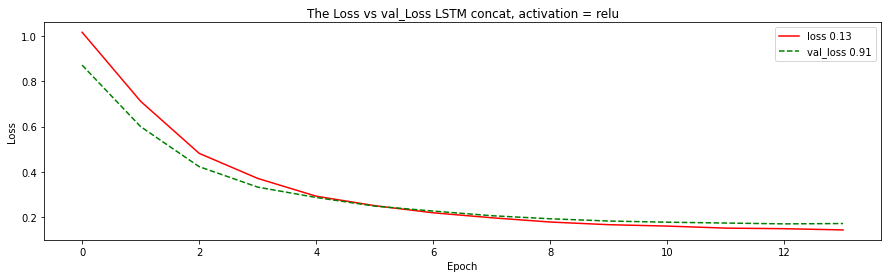

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore')
warnings.filterwarnings('ignore')

#plot the accuracy 
plt.figure(figsize=(15,4))
plt.plot(history.history['loss'], 'r', label=f'loss {round(score[0],2)}')
plt.plot(history.history['val_loss'], 'g--', label=f'val_loss {round(score[1],2)}')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('The Loss vs val_Loss LSTM concat, activation = relu')
plt.legend(loc='best');

### Saving/restoring the model

In [27]:
# concat_biLstm.save('/content/drive/MyDrive/ai_assignment_aidock/data/my_model-91-13-tfidf.h5')

# New Section

In [25]:
# new_model = tf.keras.models.load_model('my_model3.h5')

In [26]:
# new_model.summary()